# Dataset Extraction

In [1]:
import os
import zipfile
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from matplotlib.ticker import FuncFormatter
from itertools import cycle

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Paths
zip_path = '/content/drive/MyDrive/dataset/test.zip'
extract_root = '/content/dataset/test_extract'

# 1. Unzip
os.makedirs(extract_root, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_root)

# 2. Find images/ and labels/ folders regardless of nesting
def find_folder(root, name):
    for dirpath, dirnames, filenames in os.walk(root):
        if os.path.basename(dirpath) == name:
            return dirpath
    return None

images_dir = find_folder(extract_root, 'images')
labels_dir = find_folder(extract_root, 'labels')

if images_dir is None or labels_dir is None:
    raise FileNotFoundError("Could not find 'images' or 'labels' folder after extraction.")

print(f"Images folder: {images_dir}")
print(f"Labels folder: {labels_dir}")

Mounted at /content/drive
Images folder: /content/dataset/test_extract/test/images
Labels folder: /content/dataset/test_extract/test/labels


# Test Data Loading

In [2]:
# Define flow progression order for display
class_names = [
    'bubbly',
    'transition_bubbly-slug',
    'slug',
    'transition_slug-churn',
    'churn',
    'transition_churn-annular',
    'annular'
]

# Training order (from model)
class_order = ['annular', 'bubbly', 'churn', 'slug', 'transition_bubbly-slug', 'transition_churn-annular', 'transition_slug-churn']
display_order = class_names  # Desired display order
remap_indices = [class_order.index(c) for c in display_order]  # [1, 4, 3, 6, 2, 5, 0]

IMG_HEIGHT, IMG_WIDTH = 598, 96  # CNN input shape
IMG_CHANNELS = 3

images_path = sorted(glob.glob(os.path.join(images_dir, "*.png")))
labels_path = sorted(glob.glob(os.path.join(labels_dir, "*.txt")))

X_test = []
y_test = []

for img_path, lbl_path in zip(images_path, labels_path):
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # match training RGB
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  # (width, height)
    img = img.astype(np.float32) / 255.0  # normalize
    X_test.append(img)

    # Load YOLO label
    with open(lbl_path, "r") as f:
        first_line = f.readline().strip()
        try:
            class_id = int(first_line.split()[0])
            # Validate class_id
            if class_id not in range(len(class_order)):
                print(f"Warning: Invalid class_id {class_id} in {lbl_path}, skipping")
                continue

            remapped_class_id = np.where(np.array(remap_indices) == class_id)[0][0]
            y_test.append(remapped_class_id)
        except (IndexError, ValueError) as e:
            print(f"Error reading label {lbl_path}: {e}, skipping")
            continue

X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int32)


y_test_categorical = to_categorical(y_test, num_classes=len(class_names))

print(f"Loaded {len(X_test)} test images and {len(y_test)} labels")

Loaded 415 test images and 415 labels


# Model Loading and Prediction

In [3]:
# Load the saved CNN model
model_path = '/content/drive/MyDrive/model/cnn_mpfp3.keras'
cnn_model = load_model(model_path)

# Predict
y_pred_probs = cnn_model.predict(X_test)

# Handle dictionary output (multi-output model)
if isinstance(y_pred_probs, dict):
    class_preds = y_pred_probs['class_output']  # Adjust key based on model definition
else:
    class_preds = y_pred_probs


class_order = ['annular', 'bubbly', 'churn', 'slug', 'transition_bubbly-slug', 'transition_churn-annular', 'transition_slug-churn']
display_order = ['bubbly', 'transition_bubbly-slug', 'slug', 'transition_slug-churn', 'churn', 'transition_churn-annular', 'annular']
remap_indices = [class_order.index(c) for c in display_order]  # [1, 4, 3, 6, 2, 5, 0]
class_preds = class_preds[:, remap_indices]

# Get class IDs
y_pred_classes = np.argmax(class_preds, axis=-1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step


# Evaluation Metrics and Confusion Matrix

Accuracy: 0.9494
Weighted F1 Score: 0.9494

Classification Report:
                           precision    recall  f1-score   support

                  bubbly       1.00      0.98      0.99        60
  transition_bubbly-slug       0.98      1.00      0.99        60
                    slug       0.98      0.98      0.98        60
   transition_slug-churn       0.91      0.88      0.89        56
                   churn       0.83      0.85      0.84        59
transition_churn-annular       0.93      0.95      0.94        60
                 annular       1.00      1.00      1.00        60

                accuracy                           0.95       415
               macro avg       0.95      0.95      0.95       415
            weighted avg       0.95      0.95      0.95       415



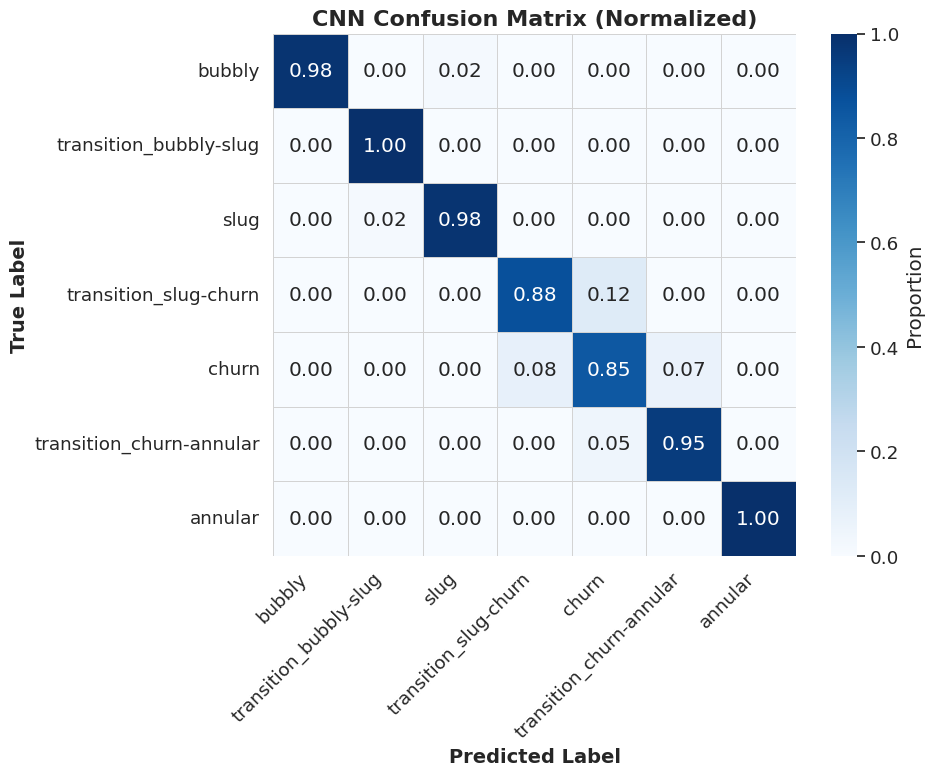

In [5]:
# Accuracy & F1
acc = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot with soft white theme
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.set(font_scale=1.2)

ax = sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    linewidths=0.5,
    linecolor='lightgray',
    square=True,
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Proportion'}
)

plt.gca().set_facecolor('white')
plt.title('CNN Confusion Matrix (Normalized)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

output_dir = '/content/drive/MyDrive/output'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'cnn_confusion_matrix.png'), dpi=300, facecolor='white')
plt.show()

# ROC Curves Visualization

class_preds shape: (415, 7)
y_test_bin shape: (415, 7)
Macro-average AUC: 0.9965


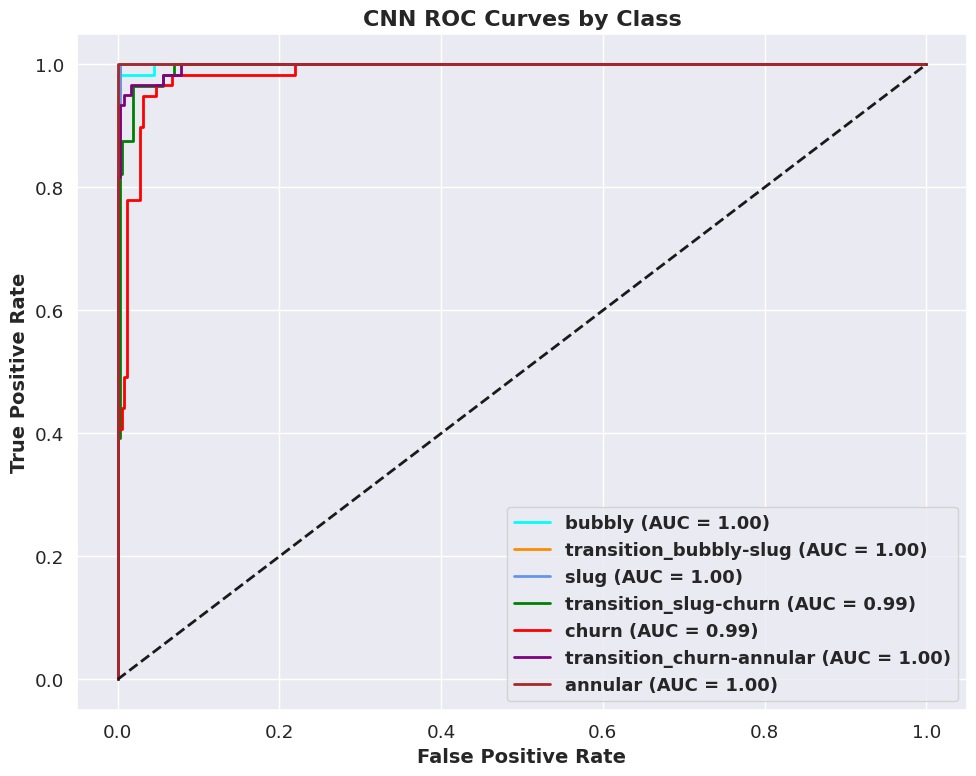

In [6]:
# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=list(range(len(class_names))))
n_classes = y_test_bin.shape[1]

print("class_preds shape:", class_preds.shape)
print("y_test_bin shape:", y_test_bin.shape)

# Compute ROC curve & AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], class_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average AUC
macro_auc = np.mean(list(roc_auc.values()))
print(f"Macro-average AUC: {macro_auc:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('CNN Confusion Matrix (Normalized)', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('CNN ROC Curves by Class', fontsize=16, fontweight='bold')

# 🔧 Customize legend: bold and larger font
legend = plt.legend(loc="lower right", fontsize=13)
for text in legend.get_texts():
    text.set_fontweight('bold')

plt.tight_layout()

# Save high-resolution
output_dir = '/content/drive/MyDrive/output'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'cnn_roc_curves_bold_auc.png'), dpi=300)
plt.show()

# Example Predictions Visualization

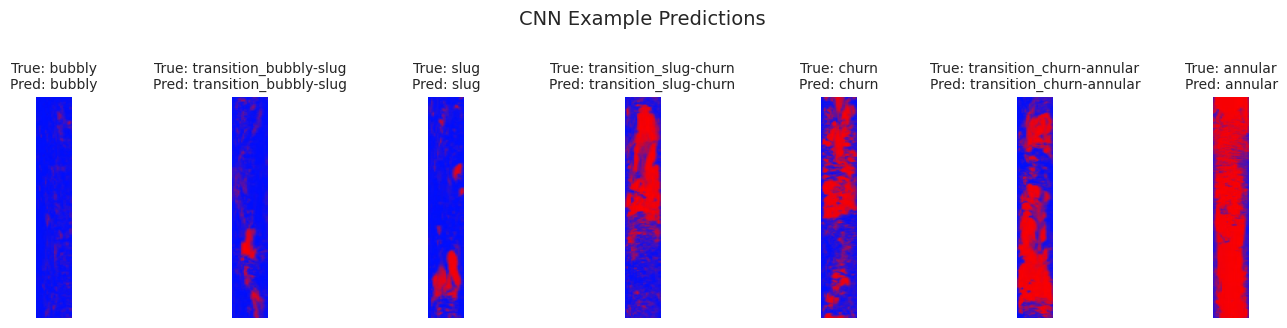

In [7]:
# Find one example per class from y_test
unique_classes = np.unique(y_test)
fig, axes = plt.subplots(1, len(unique_classes), figsize=(15, 3))

for i, class_id in enumerate(unique_classes):
    # Get index of first occurrence of class_id in y_test
    idx = np.where(y_test == class_id)[0][0]

    # Load original image from path
    img_path = images_path[idx]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

    # Get true and predicted labels
    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_pred_classes[idx]]

    # Plot
    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('CNN Example Predictions', fontsize=14, y=1.1)

# Save high-resolution
output_dir = '/content/drive/MyDrive/output'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'cnn_example_predictions.png'), dpi=300, bbox_inches='tight')
plt.show()

# Grad-CAM Visualization

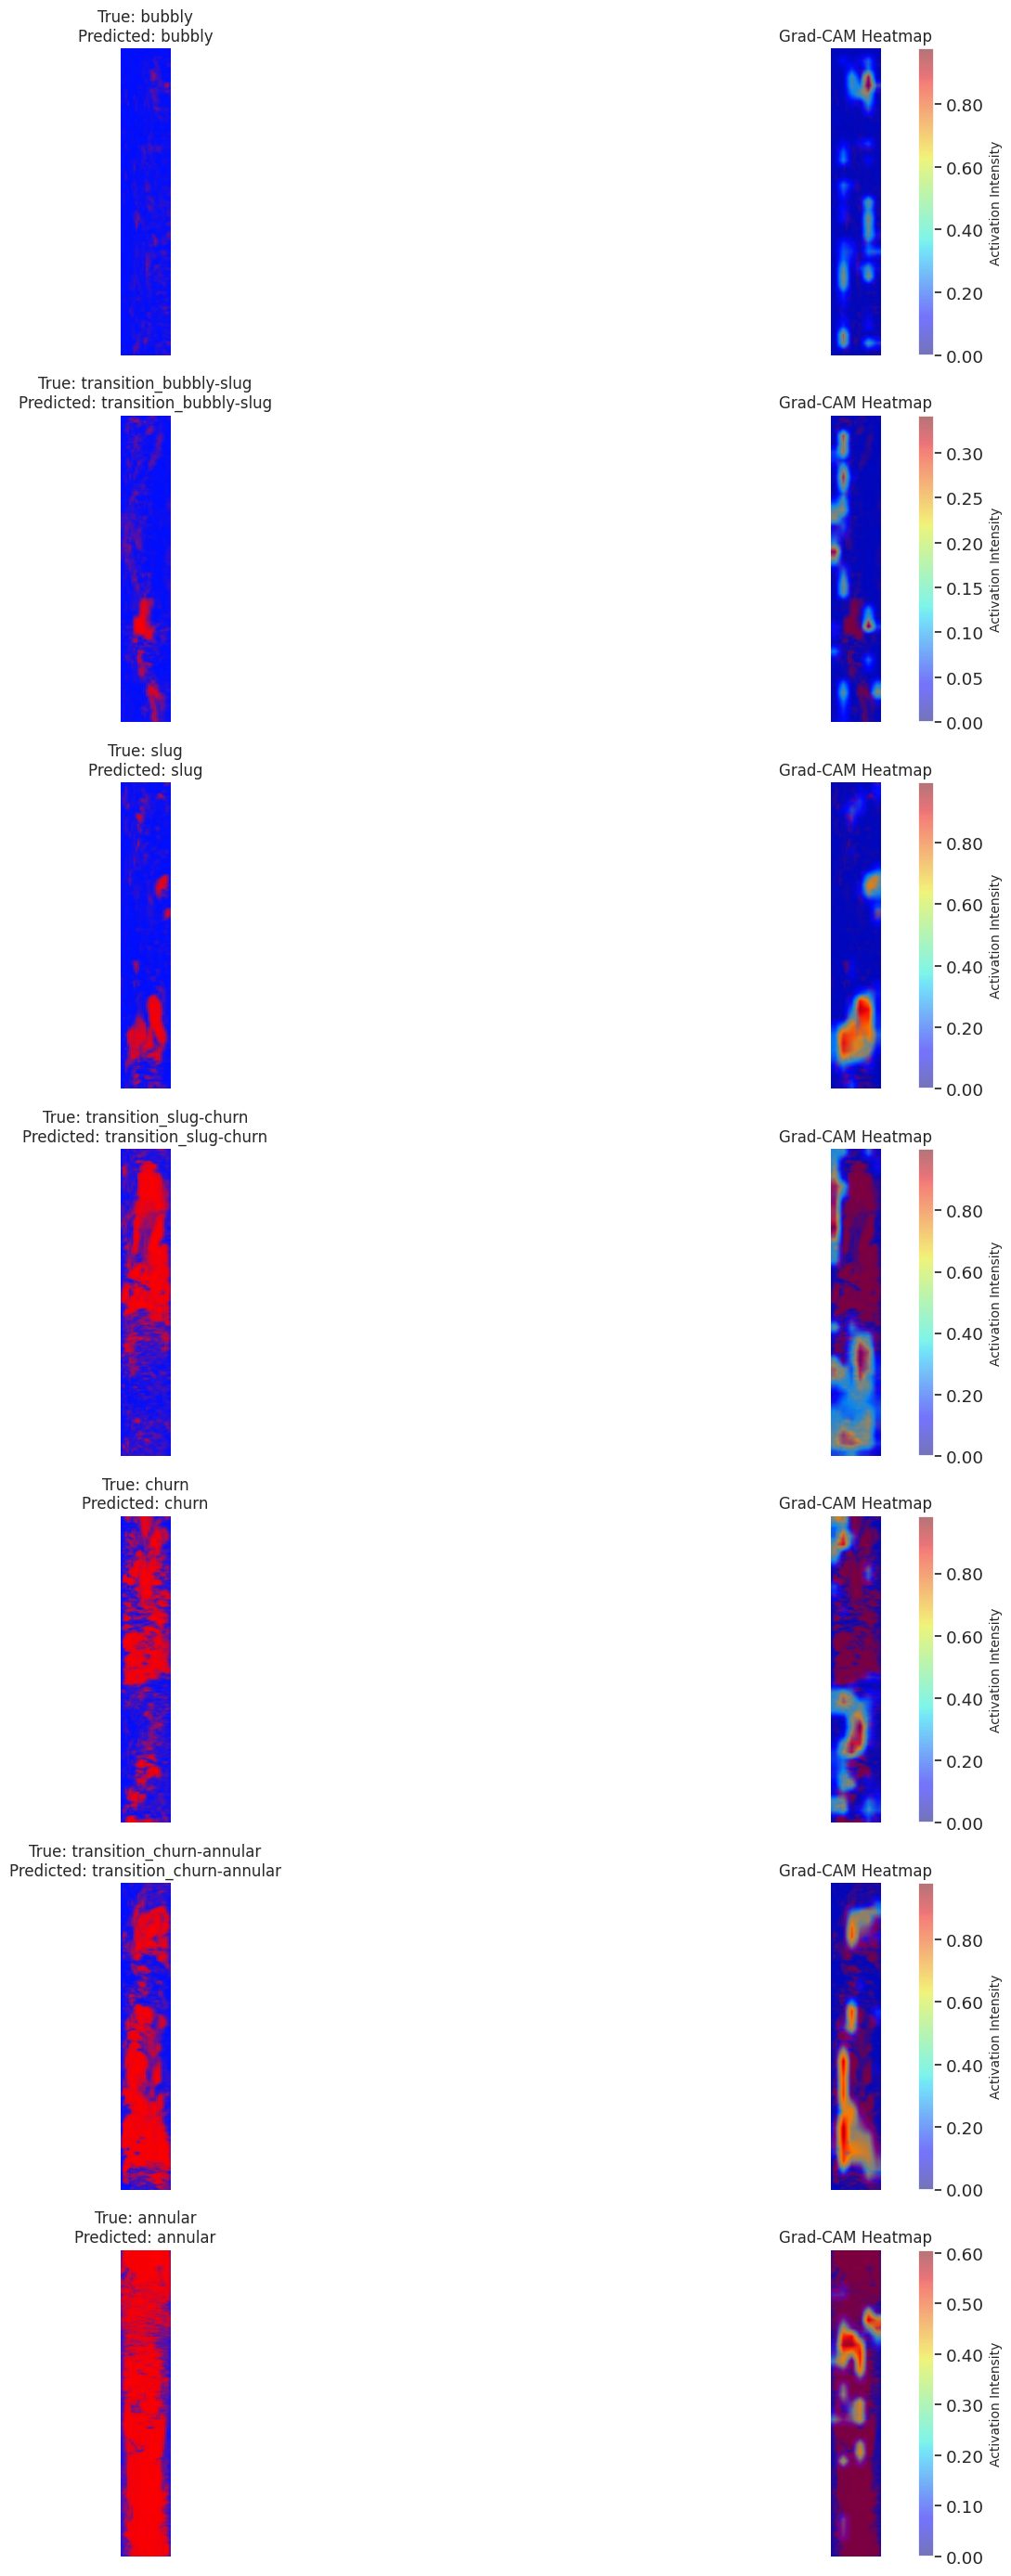

Saved to cnn_gradcam.png


In [8]:
# Grad-CAM Setup
def compute_gradcam(model, image, class_index, layer_name='conv2d_4'):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.get_layer('class_output').output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_index]  # Use class_index in training order

    grads = tape.gradient(loss, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(1, 2))
    cam = tf.reduce_sum(tf.multiply(weights[:, tf.newaxis, tf.newaxis, :], conv_outputs), axis=-1)

    cam = tf.squeeze(cam)
    cam = tf.maximum(cam, 0) / (tf.reduce_max(cam) + 1e-8)
    cam = tf.image.resize(cam[..., tf.newaxis], (IMG_HEIGHT, IMG_WIDTH)).numpy()
    return cam

# Sample one correctly classified image per class
sample_by_class = {}
y_pred = np.argmax(class_preds, axis=1)  # y_pred is in display_order due to class_preds remapping

for img, true_id, pred_id in zip(X_test, y_test, y_pred):
    if true_id == pred_id and true_id not in sample_by_class:
        sample_by_class[true_id] = img
    if len(sample_by_class) == len(class_names):
        break

for class_id in range(len(class_names)):
    if class_id not in sample_by_class:
        sample_by_class[class_id] = np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

# Visualization with Scale Bar
plt.figure(figsize=(15, 4 * len(class_names)))
for i, display_class_id in enumerate(range(len(class_names))):
    image = tf.expand_dims(sample_by_class[display_class_id], axis=0)
    pred_probs = cnn_model(image)['class_output'].numpy()[0]  # Predictions in training order
    # Map predicted probabilities to display order
    pred_probs_display = pred_probs[remap_indices]
    pred_id_display = int(np.argmax(pred_probs_display))  # Predicted ID in display order

    # Map display_class_id to training class index for Grad-CAM
    training_class_id = remap_indices[display_class_id]
    cam = compute_gradcam(cnn_model, image, class_index=training_class_id)

    true_label = class_names[display_class_id]
    pred_label = class_names[pred_id_display]

    # Original image
    plt.subplot(len(class_names), 2, 2 * i + 1)
    plt.imshow(sample_by_class[display_class_id])
    plt.title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=12)
    plt.axis("off")

    # Grad-CAM with scale bar
    plt.subplot(len(class_names), 2, 2 * i + 2)
    plt.imshow(sample_by_class[display_class_id])
    im = plt.imshow(tf.squeeze(cam), cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Heatmap", fontsize=12)
    plt.axis("off")
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label('Activation Intensity', fontsize=10)
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))

plt.tight_layout()
plt.savefig(os.path.join('/content/drive/MyDrive/output', 'cnn_gradcam.png'))
plt.show()
print("Saved to cnn_gradcam.png")